<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-TensorFlow/blob/main/Time-Series-for-Deep-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the dataset

In [1]:
import tensorflow as tf

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

13568290/13568290 [==============================] - 0s 0us/step


# Data preprocessing

In [3]:
import os
csv_path, _ = os.path.splitext(zip_path)
csv_path

'/root/.keras/datasets/jena_climate_2009_2016.csv'

In [4]:
with open(csv_path) as f:
    data = f.read()

In [5]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

In [7]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

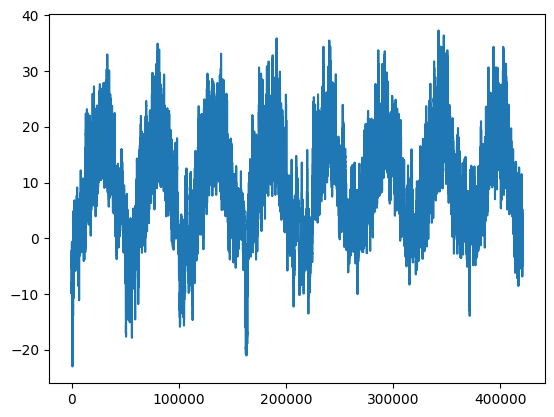

In [8]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

# Splitting the dataset

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


In [10]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = int(0.25 * len(raw_data))


print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105137


In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


# Simple approach

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 55s 60ms/step - loss: 14.3495 - mae: 2.9231 - val_loss: 11.0711 - val_mae: 2.6285
Epoch 2/10
819/819 [==============================] - 49s 59ms/step - loss: 9.6390 - mae: 2.4494 - val_loss: 10.7835 - val_mae: 2.6007
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 8.7941 - mae: 2.3369 - val_loss: 10.2959 - val_mae: 2.5355
Epoch 4/10
819/819 [==============================] - 49s 59ms/step - loss: 8.3182 - mae: 2.2712 - val_loss: 10.5033 - val_mae: 2.5657
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 7.9960 - mae: 2.2262 - val_loss: 11.8057 - val_mae: 2.7211
Epoch 6/10
819/819 [==============================] - 40s 48ms/step - loss: 7.7445 - mae: 2.1901 - val_loss: 12.5090 - val_mae: 2.7946
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 7.5109 - mae: 2.1569 - val_loss: 11.2176 - val_mae: 2.6549
Epoch 8/10
819/819 [==============================] - 

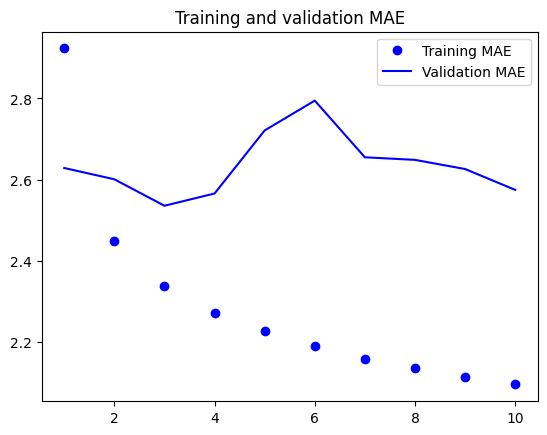

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# A 1D convolutional model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 51ms/step - loss: 21.3521 - mae: 3.6369 - val_loss: 15.6529 - val_mae: 3.1165
Epoch 2/10
819/819 [==============================] - 49s 59ms/step - loss: 15.4558 - mae: 3.1236 - val_loss: 18.8381 - val_mae: 3.4641
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 14.1732 - mae: 2.9878 - val_loss: 14.6826 - val_mae: 3.0305
Epoch 4/10
819/819 [==============================] - 41s 49ms/step - loss: 13.2536 - mae: 2.8843 - val_loss: 15.2565 - val_mae: 3.0769
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 12.6052 - mae: 2.8085 - val_loss: 16.6909 - val_mae: 3.2283
Epoch 6/10
819/819 [==============================] - 49s 60ms/step - loss: 12.0452 - mae: 2.7433 - val_loss: 16.5472 - val_mae: 3.2102
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 11.6104 - mae: 2.6941 - val_loss: 19.4440 - val_mae: 3.4653
Epoch 8/10
819/819 [============================

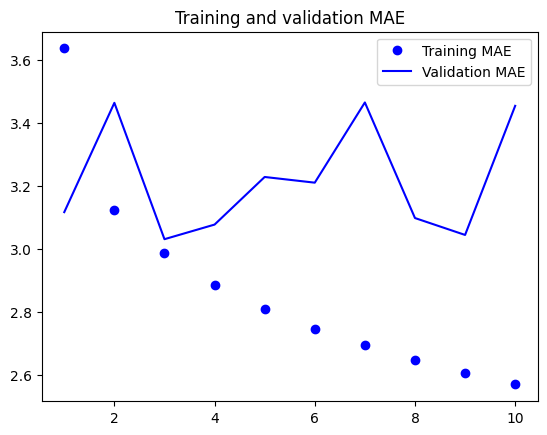

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# A simple LSTM-based model

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 54ms/step - loss: 42.3126 - mae: 4.7369 - val_loss: 12.5882 - val_mae: 2.7002
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 10.8790 - mae: 2.5639 - val_loss: 9.7209 - val_mae: 2.4205
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 9.6487 - mae: 2.4250 - val_loss: 9.6389 - val_mae: 2.4056
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 9.1880 - mae: 2.3598 - val_loss: 9.6937 - val_mae: 2.3998
Epoch 5/10
819/819 [==============================] - 52s 63ms/step - loss: 8.7595 - mae: 2.3003 - val_loss: 9.5999 - val_mae: 2.3941
Epoch 6/10
819/819 [==============================] - 52s 63ms/step - loss: 8.3216 - mae: 2.2496 - val_loss: 11.7957 - val_mae: 2.5154
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 7.9972 - mae: 2.2109 - val_loss: 11.3161 - val_mae: 2.4879
Epoch 8/10
819/819 [==============================] - 44s

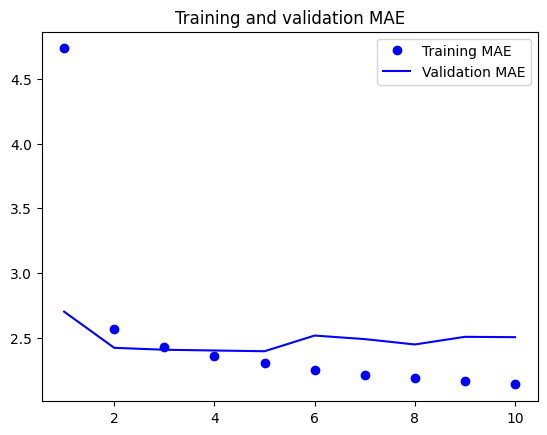

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()